In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as dates
import numpy as np
import tensorflow as tf
import keras
from datetime import timedelta
import calendar

# Preprocessing data

In [2]:
df = pd.read_csv("dataset/data_daily.csv", parse_dates=True) # reading data from csv file
df[['year', 'month', 'day']] = df['# Date'].str.split('-', expand=True)
df[['year', 'month', 'day']] = df[['year', 'month', 'day']].apply(np.float64)
df['# Date'] = pd.to_datetime(df['# Date'])
df.head()

,# Date,Receipt_Count,year,month,day
0,2021-01-01,7564766,2021.0,1.0,1.0
1,2021-01-02,7455524,2021.0,1.0,2.0
2,2021-01-03,7095414,2021.0,1.0,3.0
3,2021-01-04,7666163,2021.0,1.0,4.0
4,2021-01-05,7771289,2021.0,1.0,5.0


In [3]:
# Data available of 2022
df_next_yr = pd.DataFrame()
base = max(df['# Date']) + timedelta(days=1)
df_next_yr['# Date'] = [base + timedelta(x) for x in range(365)]
df_next_yr['year'] = df['year']+1
df_next_yr[['month', 'day']] = df[['month', 'day']]
df_next_yr.head()

,# Date,year,month,day
0,2022-01-01,2022.0,1.0,1.0
1,2022-01-02,2022.0,1.0,2.0
2,2022-01-03,2022.0,1.0,3.0
3,2022-01-04,2022.0,1.0,4.0
4,2022-01-05,2022.0,1.0,5.0


In [4]:
# For testing purposes
df_entire = pd.concat([df, df_next_yr])
df_entire = df_entire.drop(['Receipt_Count'], axis=1)
df_entire

,# Date,year,month,day
0,2021-01-01,2021.0,1.0,1.0
1,2021-01-02,2021.0,1.0,2.0
2,2021-01-03,2021.0,1.0,3.0
3,2021-01-04,2021.0,1.0,4.0
4,2021-01-05,2021.0,1.0,5.0
...,...,...,...,...
360,2022-12-27,2022.0,12.0,27.0
361,2022-12-28,2022.0,12.0,28.0
362,2022-12-29,2022.0,12.0,29.0
363,2022-12-30,2022.0,12.0,30.0


In [5]:
m, n = df.shape

# Exploratory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   # Date         365 non-null    datetime64[ns]
 1   Receipt_Count  365 non-null    int64         
 2   year           365 non-null    float64       
 3   month          365 non-null    float64       
 4   day            365 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 14.4 KB


In [7]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
# Date,365,2021-07-02 00:00:00,2021-01-01 00:00:00,2021-04-02 00:00:00,2021-07-02 00:00:00,2021-10-01 00:00:00,2021-12-31 00:00:00,NaN
Receipt_Count,365.0,8826566.052055,7095414.0,8142874.0,8799249.0,9476970.0,10738865.0,782008.894052
year,365.0,2021.0,2021.0,2021.0,2021.0,2021.0,2021.0,0.0
month,365.0,6.526027,1.0,4.0,7.0,10.0,12.0,3.452584
day,365.0,15.720548,1.0,8.0,16.0,23.0,31.0,8.808321


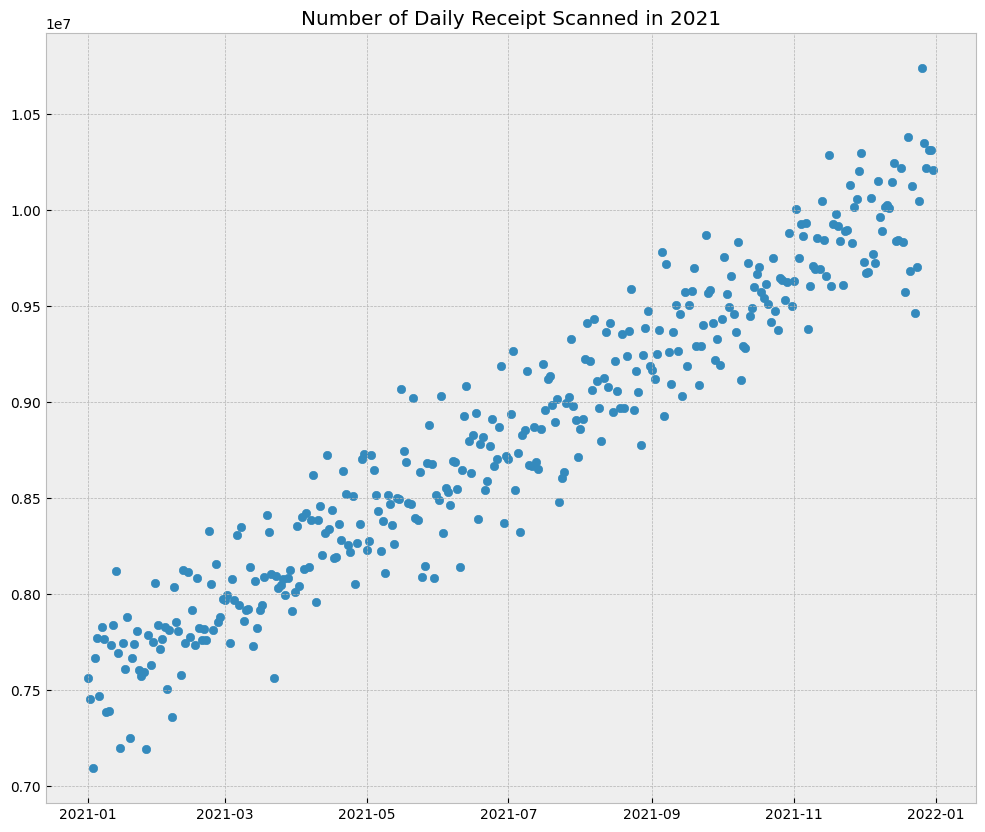

In [34]:
plt.style.use('bmh')

fig, ax  = plt.subplots(1, figsize=(12,10))

ax.scatter(df['# Date'], df['Receipt_Count'])
# ax.xaxis.set_minor_locator(dates.MonthLocator())
# ax.xaxis.set_major_formatter(dates.DateFormatter('%b %Y'))
ax.set_title("Number of Daily Receipt Scanned in " + str(int(df['year'][0])))
plt.savefig("images/training_data.png")
plt.show()

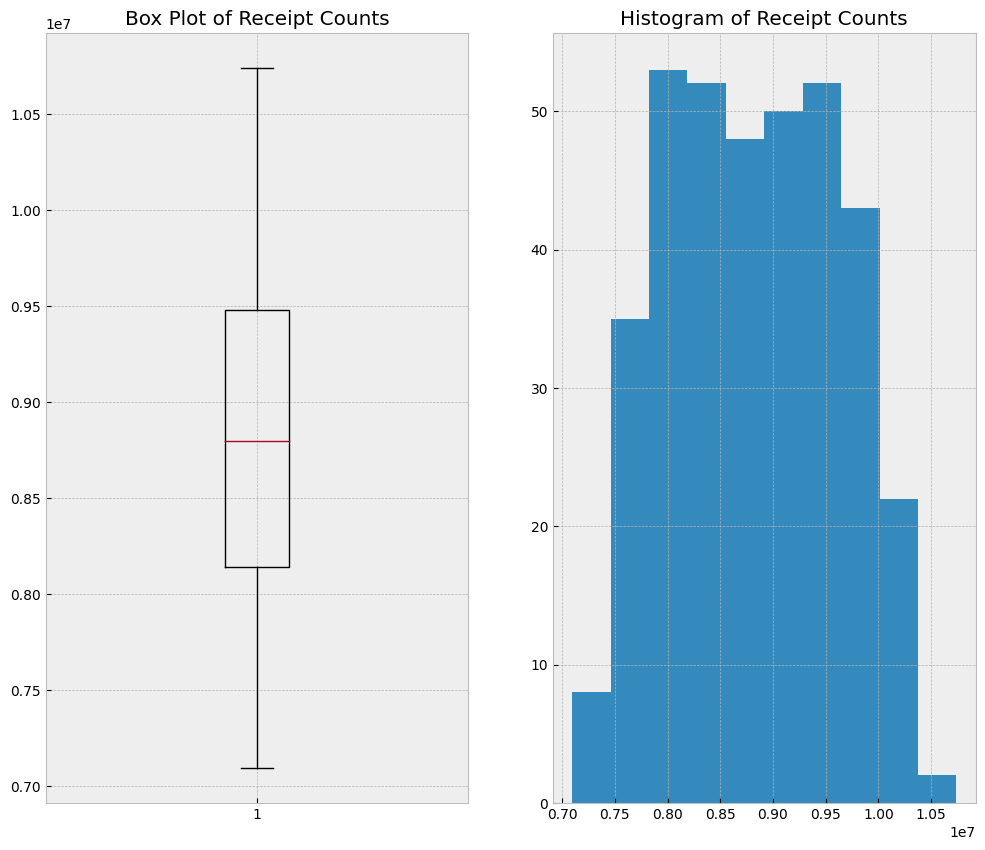

In [35]:
# checking for outliers
plt.style.use('bmh')

fig, ax  = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12,10))
# fig.figure()
ax[0].boxplot(df['Receipt_Count'])
ax[0].set_title('Box Plot of Receipt Counts')

ax[1].hist(df['Receipt_Count'])
ax[1].set_title('Histogram of Receipt Counts')
plt.savefig("images/box_hist.png")
plt.show()

In [10]:
# identifying the features available to consider in the model
features = list(df.columns)
output_variable = 'Receipt_Count' # variable that we want to predict
features.remove(output_variable)
features.remove('# Date')


# Processing Data

In [11]:
# splitting data for training and testing
df_training = df.sample(frac=0.8, random_state=0)
df_testing = df.drop(df_training.index)

In [12]:
# Function to normalize data
# since there is no negative number in this data, dividing by the maximum value is enough for normalization
def normalize(dataframe):
    return dataframe/dataframe.max(), dataframe.max()

# Function to reverse normalization
def inverse_normalize(dataframe, Max):
    return dataframe*Max

In [13]:
df_training_normalized, max_training = normalize(df_training[features + [output_variable]])
df_testing_normalized, max_testing = normalize(df_testing[features + [output_variable]])

df_entire_normalize, df_entire_max = normalize(df_entire[features])
df_normalized, df_inverse_max = normalize(df[features + [output_variable]])

# Building model

In [14]:
opt = keras.optimizers.legacy.Adam(learning_rate=0.001)
def build_model ():
    model = keras.Sequential([
        tf.keras.layers.Dense(3, activation=tf.nn.relu, input_shape=[len(features)]),
        tf.keras.layers.Dense(6, activation=tf.nn.relu),
        tf.keras.layers.Dense(3, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=opt,
                  loss='mse',  
                  metrics='mae')
    return model

In [15]:
df_training.shape

(292, 5)

In [16]:
model = build_model()
model.summary() # checking if the number of parameters is adequated to the size of the data available for training

2023-11-10 17:47:01.025963: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-11-10 17:47:01.025983: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-10 17:47:01.025988: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-10 17:47:01.026019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-10 17:47:01.026032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 12        
                                                                 
 dense_1 (Dense)             (None, 6)                 24        
                                                                 
 dense_2 (Dense)             (None, 3)                 21        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 61 (244.00 Byte)
Trainable params: 61 (244.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# callback to stop training if model stops learning to avoid overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.00001, patience=20)
trained_model = model.fit(df_training_normalized[features], df_training_normalized[[output_variable]], epochs=500, 
                          validation_split=0.2,
                          callbacks=callback)

Epoch 1/500


2023-11-10 17:47:02.763153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 0.8605 - mae: 0.9207 

2023-11-10 17:47:05.733673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 4s 276ms/step - loss: 0.8605 - mae: 0.9207 - val_loss: 0.7284 - val_mae: 0.8460
Epoch 2/500
8/8 [==============================] - 0s 10ms/step - loss: 0.6757 - mae: 0.8144 - val_loss: 0.5567 - val_mae: 0.7381
Epoch 3/500
8/8 [==============================] - 0s 9ms/step - loss: 0.5103 - mae: 0.7058 - val_loss: 0.4071 - val_mae: 0.6294
Epoch 4/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3694 - mae: 0.5982 - val_loss: 0.2845 - val_mae: 0.5238
Epoch 5/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2551 - mae: 0.4947 - val_loss: 0.1891 - val_mae: 0.4239
Epoch 6/500
8/8 [==============================] - 0s 9ms/step - loss: 0.1676 - mae: 0.3977 - val_loss: 0.1187 - val_mae: 0.3318
Epoch 7/500
8/8 [==============================] - 0s 8ms/step - loss: 0.1049 - mae: 0.3087 - val_loss: 0.0696 - val_mae: 0.2481
Epoch 8/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0614 - mae: 0.2295 - val_loss: 0.

In [33]:
model.save_weights("/Users/karendamata/Library/Mobile Documents/com~apple~CloudDocs/GitHubProjects/Fetch-Assessment/checkpoints/my_checkpoint")

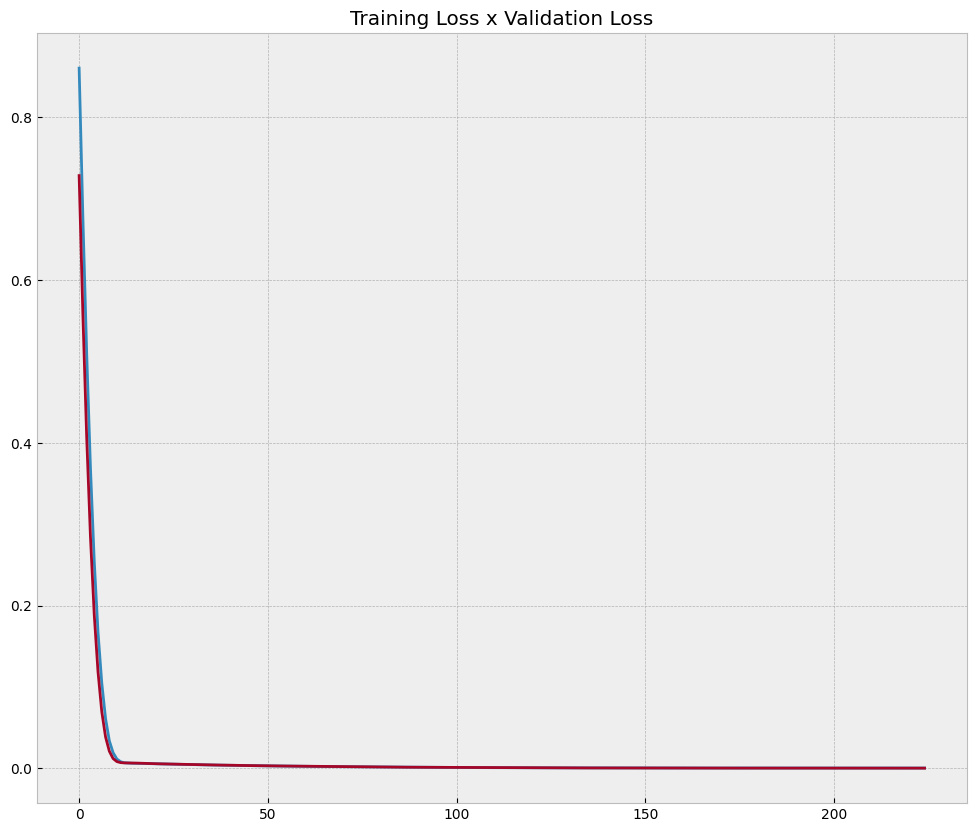

In [36]:
plt.style.use('bmh')
fig, ax = plt.subplots(1, figsize=(12,10))
ax.plot(trained_model.history['loss'])
ax.plot(trained_model.history['val_loss'])
ax.set_title("Training Loss x Validation Loss")
plt.savefig("images/lossVSval.png")
plt.show()

In [19]:
pred = model.predict(df_entire_normalize[features])
pred_not_normalized = inverse_normalize(pd.DataFrame(pred,columns=['Receipt_Count']), df_inverse_max[[output_variable]])

 1/23 [>.............................] - ETA: 3s

2023-11-10 17:47:36.625147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 11ms/step


In [20]:
#Evaluation considering the entire normalized data.
evaluation = model.evaluate(df_normalized[features], df_normalized[[output_variable]])

12/12 [==============================] - 0s 36ms/step - loss: 4.1525e-04 - mae: 0.0161


In [21]:
for i in range(len(evaluation)): evaluation[i] = evaluation[i] * df_inverse_max[[output_variable]][0]
print("Not normalized Error: ")
print(f"MSE: {evaluation[0]}, MAE: {evaluation[1]}")

Not normalized Error: 
MSE: 4459.272949101141, MAE: 173135.52514212206


In [24]:
error_df = pd.DataFrame()
error_df['MSE'] = [4.1341e-04, 4439.594673006941]
error_df['MAE'] = [0.0160, 171896.35819923133]

In [25]:
error_df.index = ['Normalized Error', 'Not Normalized Error']
error_df

,MSE,MAE
Normalized Error,0.000413,0.016000
Not Normalized Error,4439.594673,171896.358199


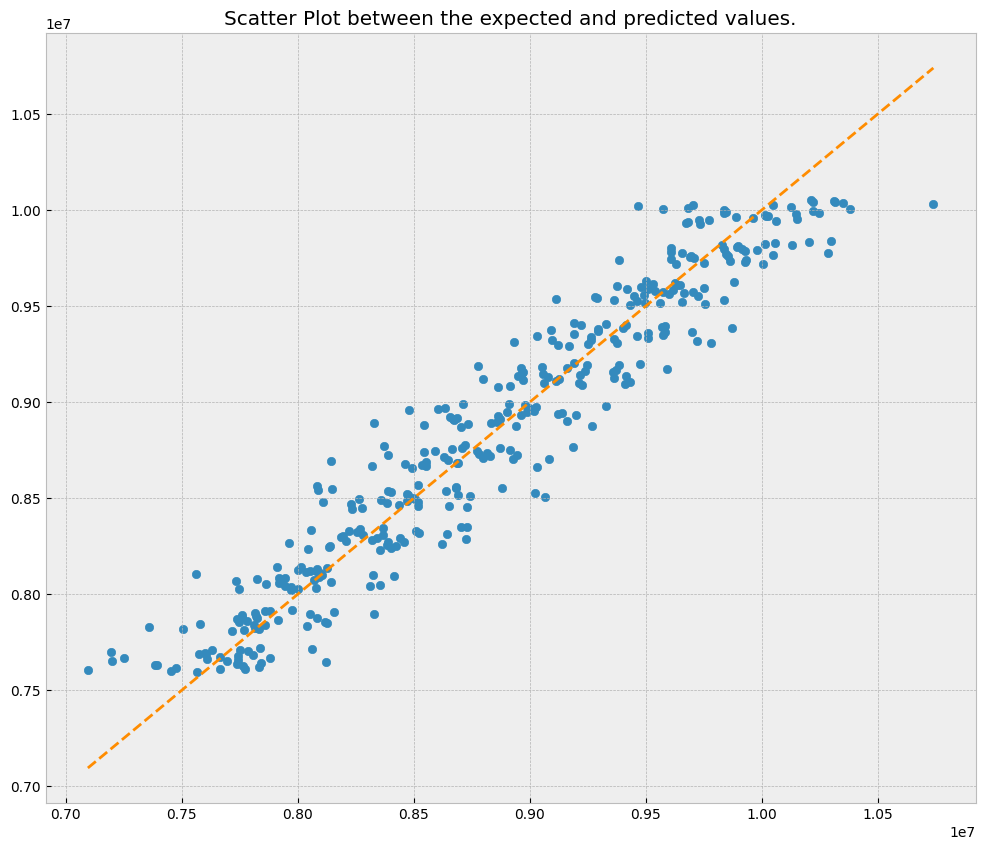

In [37]:
#Analyzing the model residuals
plt.style.use('bmh')

fig, ax  = plt.subplots(1, figsize=(12,10))

ax.scatter(df['Receipt_Count'], pred_not_normalized[:365])

line_coords = np.arange(df['Receipt_Count'].min().min(), df['Receipt_Count'].max().max())
ax.plot(line_coords, line_coords, color='darkorange', linestyle='--')
ax.set_title('Scatter Plot between the expected and predicted values.')
plt.savefig("images/modelExpectedVSPredicted.png")
plt.show()

In [38]:
df_entire

,# Date,year,month,day,Receipt_Count
0,2021-01-01,2021.0,1.0,1.0,7.596353e+06
1,2021-01-02,2021.0,1.0,2.0,7.600447e+06
2,2021-01-03,2021.0,1.0,3.0,7.604543e+06
3,2021-01-04,2021.0,1.0,4.0,7.608640e+06
4,2021-01-05,2021.0,1.0,5.0,7.612734e+06
...,...,...,...,...,...
360,2022-12-27,2022.0,12.0,27.0,1.003544e+07
361,2022-12-28,2022.0,12.0,28.0,1.003953e+07
362,2022-12-29,2022.0,12.0,29.0,1.004363e+07
363,2022-12-30,2022.0,12.0,30.0,1.004773e+07


In [39]:
# for visualization purposes, inserting the predicted receipt counts into the dataframe df_entire
# df_entire.insert(1, 'Receipt_Count', pred_not_normalized)
df_entire['Receipt_Count'] = pred_not_normalized

In [40]:
#  summing up the number of receipts received at each month 
monthly_2021 = df[['year', 'month',output_variable]].groupby(by='month').sum()[[output_variable]]
monthly_2021.index = list(calendar.month_name)[1:]

monthly_2022 = df_entire[365:][['year', 'month',output_variable]].groupby(by='month').sum()[[output_variable]]
monthly_2022.index = list(calendar.month_name)[1:]

In [ ]:
df_entire[365:]['year'][0]

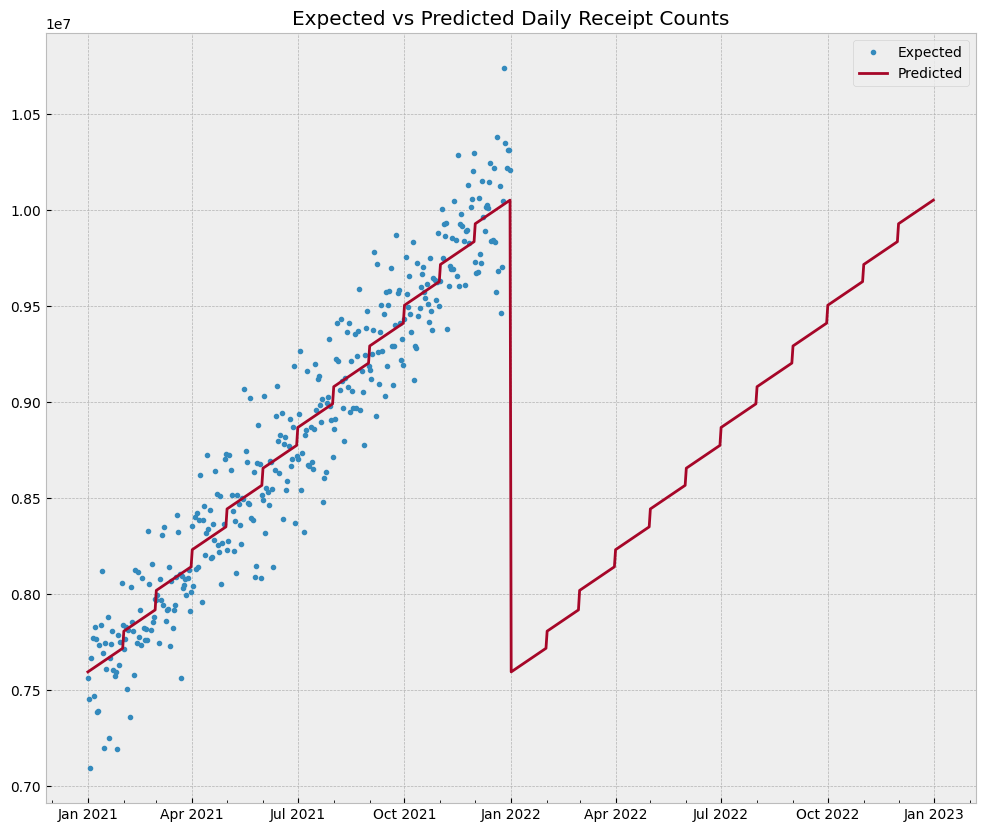

In [41]:
plt.style.use('bmh')

fig, ax  = plt.subplots(1, figsize=(12,10))

ax.plot(df['# Date'], df[[output_variable]], '.', label='Expected')
ax.plot(df_entire['# Date'], df_entire[[output_variable]], label='Predicted')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%b %Y'))
ax.set_title('Expected vs Predicted Daily Receipt Counts')
plt.legend()
plt.savefig("images/ExpectedVSPredicted.png")
plt.show()

In [42]:
# computing the difference of monthly receipt counts between 2021 and 2022
diff = [value[0] for value in (monthly_2022-monthly_2021).to_numpy()]

# identifying the bar color for each month according to the difference of monthly receipt previous calculated
# green represents an increase, and red a decrease
colors = ['green' if diff[i]>0 else 'red' for i in range(len(diff))] 

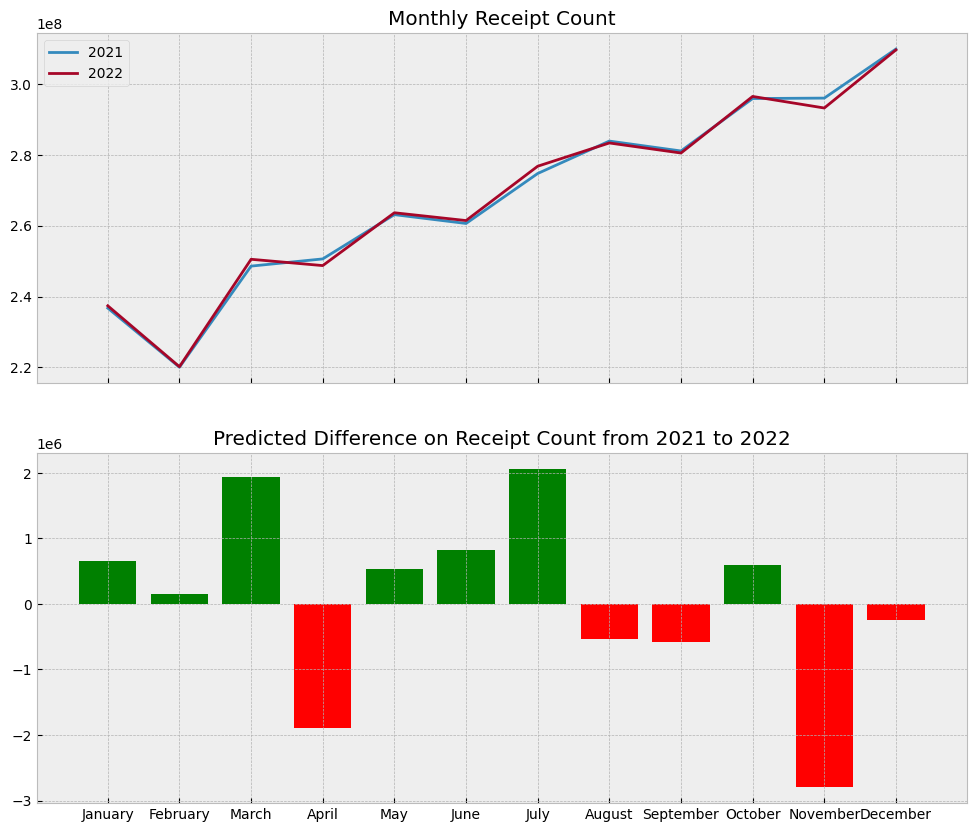

In [43]:
plt.style.use('bmh')

fig, ax  = plt.subplots(2, sharex=True, sharey=False, figsize=(12,10))

ax[0].plot(monthly_2021, label='2021')
ax[0].plot(monthly_2022, label='2022')
ax[0].legend()
ax[0].set_title('Monthly Receipt Count')

ax[1].bar(monthly_2022.index, diff, color=colors)
ax[1].set_title('Predicted Difference on Receipt Count from 2021 to 2022')
plt.savefig("images/Improvement21vs22.png")
plt.show()